In [2]:
from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites
from pycolab.rendering import ObservationToFeatureArray

import numpy as np
import pycolab

import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

# Implementations

### Environments

#### 1. Blocking Maze

In [3]:
BLOCKING_MAZE = [
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '######### #',
     '#         #',
     '#         #',
     '###########'],
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# #########',
     '#         #',
     '#         #',
     '###########']
]

#### 2. Shortcut Maze

In [4]:
SHORTCUT_MAZE = [
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# #########',
     '#         #',
     '#         #',
     '###########'],
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# ####### #',
     '#         #',
     '#         #',
     '###########']
]

#### 3. Environment Mechanics

In [17]:
def make_game(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite})


def show_board(obs):
    """Displays an image of the Board."""
    board = 80 * np.array(obs.layers['P'], dtype=np.float)
    board += 15 * np.array(obs.layers['#'], dtype=np.float)
    
    goal_mask = np.zeros(shape=board.shape)
    goal_mask[GOAL_LOCATION] = 1
    board += 50 * goal_mask

    plt.figure(figsize=(4, 2))
    plt.imshow(board)
    plt.axis('off')
    plt.show()


class PlayerSprite(prefab_sprites.MazeWalker):
    """A `Sprite` for our player.
    This `Sprite` ties actions to going in the four cardinal directions. If we
    reach a magical location, the agent receives a reward of 1 and the epsiode terminates.
    """

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite, self).__init__(corner, position, character, impassable='#')
    


    def update(self, actions, board, layers, backdrop, things, the_plot):
        del layers, backdrop, things   # Unused in this application.

        # Apply motion commands.
        if actions == 0:    # walk upward?
            self._north(board, the_plot)
            #print('Walks up')
        elif actions == 1:  # walk downward?
            self._south(board, the_plot)
            #print('Walks down')
        elif actions == 2:  # walk leftward?
            self._west(board, the_plot)
            #print('Walks left')
        elif actions == 3:  # walk rightward?
            self._east(board, the_plot)
            #print('Walks right')

        # See if we've found the mystery spot.
        if self.position == GOAL_LOCATION:
            the_plot.add_reward(1.0)
            the_plot.terminate_episode()
        else:
            the_plot.add_reward(0.0)
            
class Maze(object):
    def __init__(self, arts, start, goal):
        self.arts = arts
        self.index = 0
        
        self.START = start
        self.GOAL  = goal
        
        self._showtime = False
        
    def init_art(self, art, position):
        y, x = position
        tmp = list(art[y])
        tmp[x] = "P"
        art[y] = "".join(tmp)
    
    def build(self):
        art = self.arts[self.index]
        self.init_art(art, self.START)
        self.game = make_game(art, self.GOAL)
        return self
    
    def change(self):
        if self.index == len(self.arts)-1:
            self.index = 0
        else:
            self.index += 1
            
        art = self.arts[self.index]        
        init_art(art, self.START)
        self.game = make_game(art)
        return self
    
    def its_showtime(self):
        if self._showtime:
            self.build()
            self._showtime = False
        obs, reward, gamma = self.game.its_showtime()
        self._showtime = True
        return obs, reward, gamma
    
    @property
    def rows(self):
        return self.game.rows
    
    @property
    def cols(self):
        return self.game.cols
    
    @property
    def game_over(self):
        return self.game.game_over
    
    def play(self, action):
        obs, reward, gamma = self.game.play(action)
        position = np.array(obs.layers['P'])
        self.state = np.unravel_index(position.argmax(), position.shape)
        return obs, reward, gamma

### Dyna-Q Algorithm

In [18]:
class SimpleModel(object):
    def __init__(self):
        self._mapping = dict()
    
    def feed(self, state, action, next_state, reward):
        if tuple(state) not in self._mapping.keys():
            self._mapping[tuple(state)] = dict()
        self._mapping[tuple(state)][action] = (reward, list(next_state))
    
    def sample(self):
        #
        state_index = np.random.choice(range(0, len(self._mapping.keys())))
        state = list(self._mapping)[state_index]
        #
        action_index = np.random.choice(range(0, len(self._mapping[state].keys())))
        action = list(self._mapping[state])[action_index]
        reward, next_state = self._mapping[state][action]
        return list(state), action, reward, list(next_state)

In [19]:
class DynaQ(object):
    def __init__(self, gamma=0.95, epsilon=0.1, alpha=0.1, n_planning_steps=5):
        # discount factor
        self.gamma = gamma

        # probability for exploration
        self.epsilon = epsilon

        # step size
        self.alpha = alpha

        # n-step planning
        self.n_planning_steps = n_planning_steps
        
    # action selection with epsilon-greedy scheme
    def _select_action(self, state, state_action_values):
        if np.random.binomial(1, self.epsilon) == 1:
            return np.random.randint(4)
        else:
            values = state_action_values[state[0], state[1], :]
            return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])

    # tabular dyna-Q algorithm
    def apply(self, state_action_values, model, game, n_steps, display=False):
        #
        obs, reward, gamma = game.its_showtime()
        position = np.array(obs.layers['P'])
        current_state = np.unravel_index(position.argmax(), position.shape)
        
        if display:
            show_board(obs)

        steps = 0
        while not(game.game_over):
            #
            steps += 1

            # choose an action to execute
            action = self._select_action(current_state, state_action_values)

            # take action
            obs, reward, gamma = game.play(action)
            position = np.array(obs.layers['P'])
            next_state = np.unravel_index(position.argmax(), position.shape)
            
            if display:
                show_board(obs)

            # Q-Learning update
            state_action_values[current_state[0], current_state[1], action] += \
                self.alpha * (reward + self.gamma * np.max(state_action_values[next_state[0], next_state[1], :]) -
                state_action_values[current_state[0], current_state[1], action])

            # feed the model with experience
            model.feed(current_state, action, next_state, reward)

            # sample experience from the model
            for t in range(0, self.n_planning_steps):
                sample_state, sample_action, sample_reward, sample_next_state = model.sample()
                state_action_values[sample_state[0], sample_state[1], sample_action] += \
                    self.alpha * (sample_reward + self.gamma * np.max(state_action_values[sample_next_state[0], sample_next_state[1], :]) -
                    state_action_values[sample_state[0], sample_state[1], sample_action])

            current_state = next_state
            
            if (steps > n_steps):
                break
        print(game.game_over, steps)
        return steps

In [20]:
def changing_maze_experiment(mazes, params):

    # set up max steps
    n_steps = params.n_steps

    # track the cumulative rewards
    rewards = np.zeros((n_steps,))

    for run in range(0, params.n_runs):
        print('run:', run)
        
        # instantiate dyna-Q algorithm
        agent = DynaQ()
        
        # set up model
        model = SimpleModel()

        # track cumulative reward in current run
        rewards_ = np.zeros((n_steps,))
        
        # instantiate game
        maze = Maze(mazes, start=(6, 4), goal=(1, 9))
        game = maze.build()
        index = 0

        # initialize state action values
        state_action_values = np.zeros((game.rows, game.cols, 4))

        steps = 0
        last_steps = steps
        while steps < n_steps:
            # play for an episode
            steps += agent.apply(state_action_values, model, game, n_steps, False)

            # update cumulative rewards
            steps_ = min(steps, n_steps - 1)
            rewards_[last_steps : steps_] = rewards_[last_steps]
            rewards_[steps_] = rewards_[last_steps] + 1
            last_steps = steps
            
            
            if index < len(params.change_points) and steps > params.change_points[index]:
                # change maze
                game = maze.change()
                index += 1
        rewards += rewards_

    # averaging over runs
    rewards /= params.n_runs

    return rewards

In [21]:
Params = namedtuple("Params", ["n_steps", "n_runs", "change_points"])
params = Params(n_steps=3000, n_runs=20, change_points=[1000, np.inf])

# run the experiments on both "blocking maze" and "shortcut maze"
rewards_bm = changing_maze_experiment(BLOCKING_MAZE, params)
rewards_sm = changing_maze_experiment(SHORTCUT_MAZE, params)

plt.figure(1)
plt.plot(range(0, params.n_steps), rewards_bm, label="Blocking Maze")
plt.plot(range(0, params.n_steps), rewards_sm, label="Changing Maze")
plt.title('Changing Mazes experiments with Dyna-Q')
plt.xlabel('Time steps')
plt.ylabel('Cumulative reward')
plt.legend(loc="best")
plt.show()

run: 0


NameError: name 'GOAL_LOCATION' is not defined

# Experiments

# How dows Dyna-Q relate to Experience Replay ?

# Conclusion

In [16]:
MAZES = [
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '######### #',
     '#         #',
     '#         #',
     '###########'],
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# #########',
     '#         #',
     '#         #',
     '###########']
]

# instantiate game
maze = Maze(MAZES, (6, 4), (1, 9))
maze.build()

# initialize state action values
state_action_values = np.zeros((maze.rows, maze.cols, 4))

# instantiate simple model
model = SimpleModel()

# instantiate dyna-Q algorithm
algorithm = DynaQ()

# apply algorithm
algorithm.apply(state_action_values, model, maze, 100)

# change maze
maze.change()

# apply algorithm
algorithm.apply(state_action_values, model, maze, 100)

print('GAME OVER')

False 101
False 101
GAME OVER


In [13]:
MAZE_ART = ['###########',
            '#         #',
            '#         #',
            '#         #',
            '######### #',
            '#         #',
            '#         #',
            '###########']

# instantiate game
init_art(MAZE_ART, (6, 4))
game = make_game(MAZE_ART)

# initialize state action values
state_action_values = np.zeros((game.rows, game.cols, 4))

# instantiate simple model
model = SimpleModel()

# instantiate dyna-Q algorithm
algorithm = DynaQ()

# apply algorithm
algorithm.apply(state_action_values, model, game, np.inf)

print('GAME OVER')

True 345
GAME OVER


In [8]:
class Board(object):
    def __init__(self):
        #
        self.fig, self.ax = plt.subplots(1, 1, figsize=(4, 2))
        self.ax.axis("off")
        
        #
        self.i = 0
        self.p = None
        
    def show(self, obs):

        _board = 10 * np.array(obs.layers['P'], dtype=np.float)
        _board += 2 * np.array(obs.layers['#'], dtype=np.float)

        goal_mask = np.zeros(shape=_board.shape)
        goal_mask[GOAL_LOCATION] = 1
        _board += 7 * goal_mask
        
        if self.i == 0:
            self.p = self.ax.imshow(_board)
        else:
            self.p.set_data(_board)
        
        self.i += 1
        
        plt.axis('off')
        plt.pause(0.1)

In [9]:
def init_art(art, position):
    y, x = position
    tmp = list(art[y])
    tmp[x] = "P"
    art[y] = "".join(tmp)

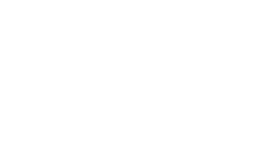

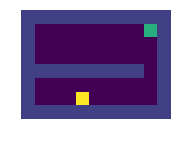

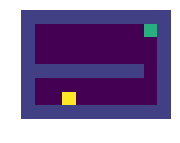

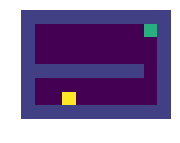

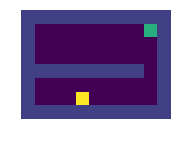

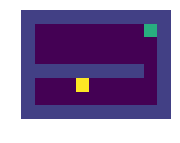

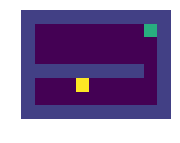

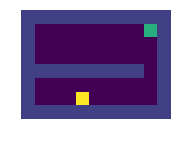

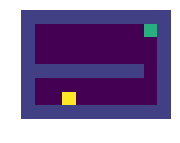

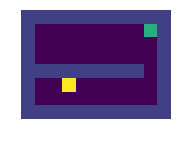

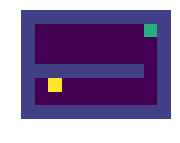

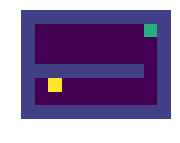

Changing Maze


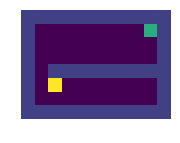

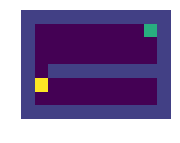

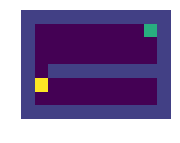

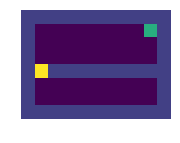

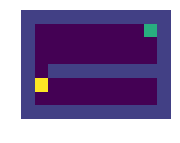

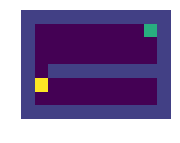

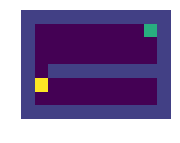

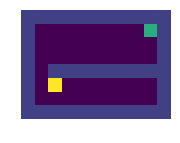

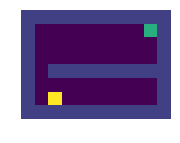

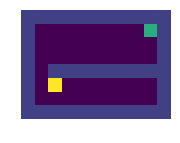

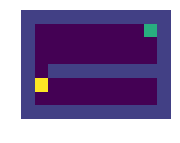

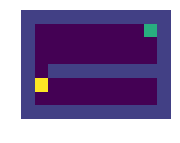

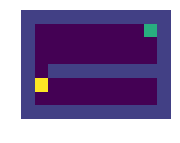

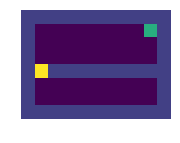

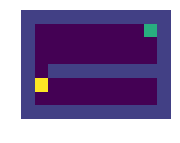

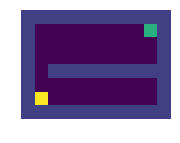

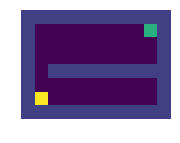

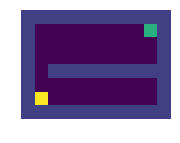

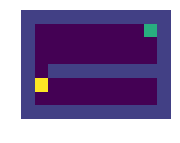

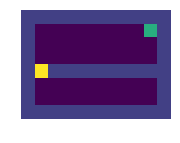

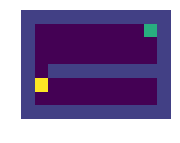

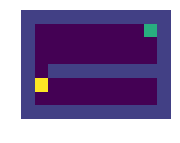

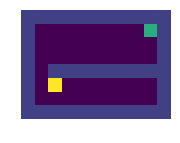

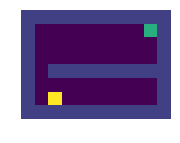

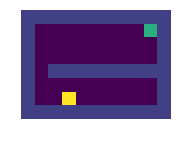

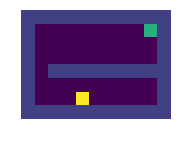

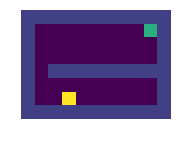

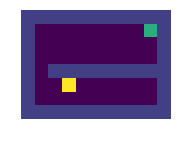

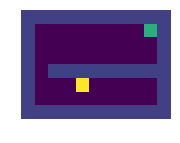

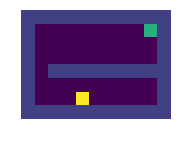

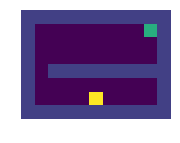

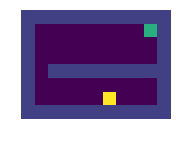

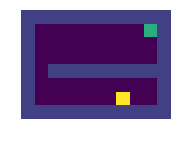

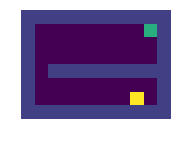

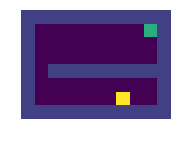

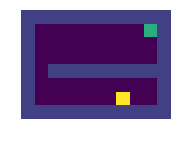

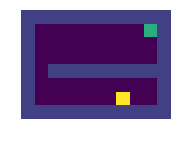

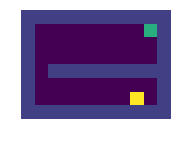

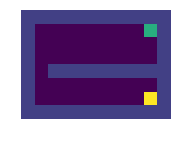

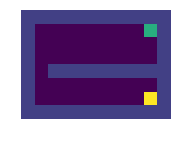

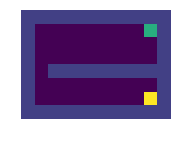

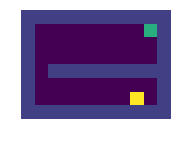

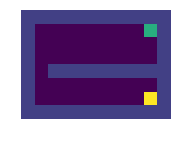

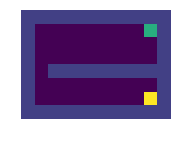

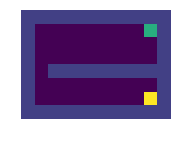

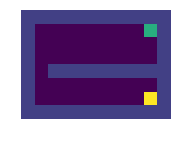

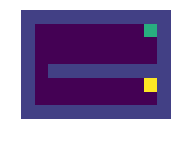

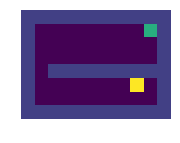

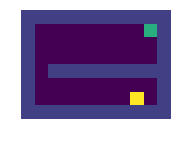

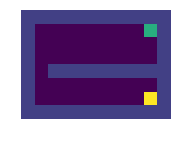

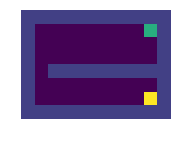

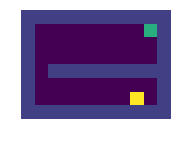

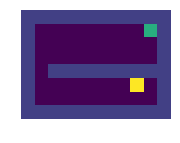

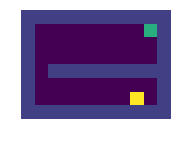

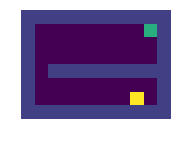

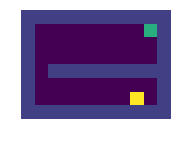

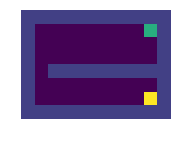

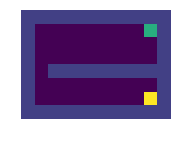

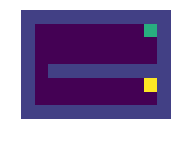

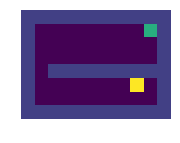

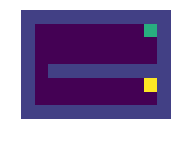

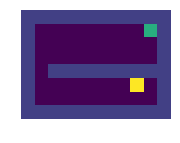

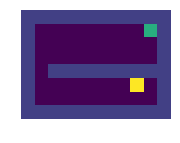

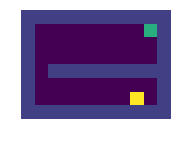

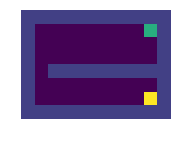

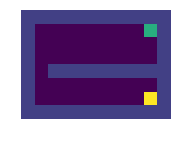

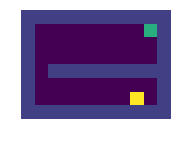

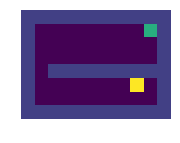

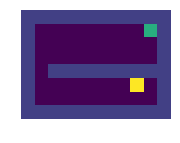

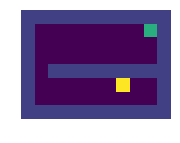

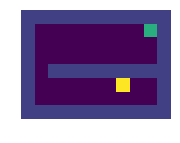

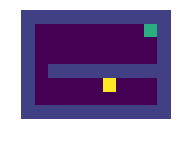

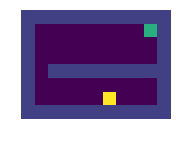

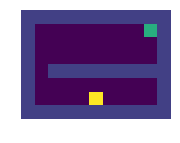

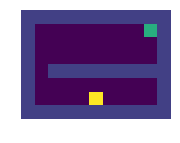

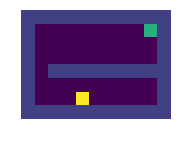

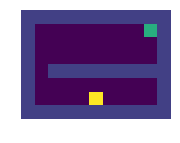

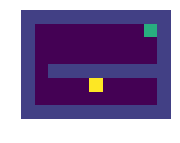

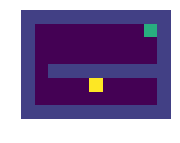

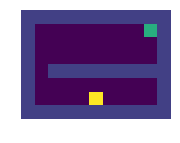

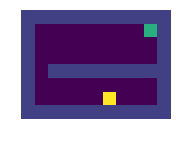

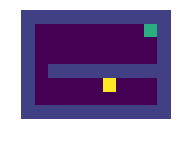

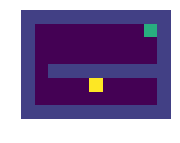

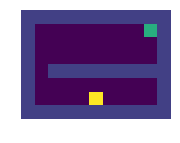

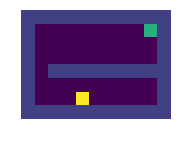

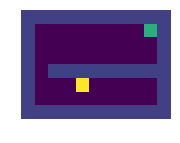

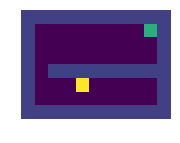

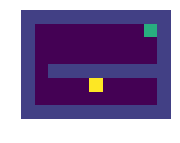

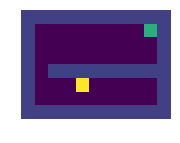

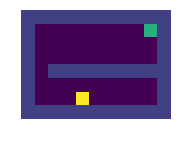

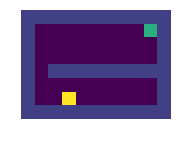

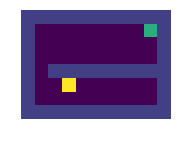

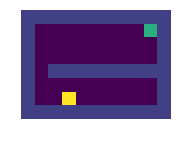

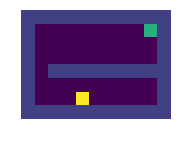

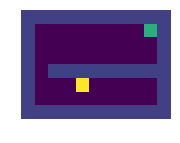

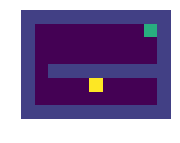

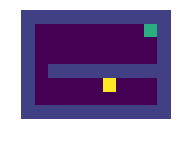

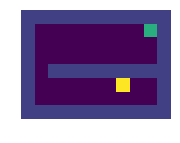

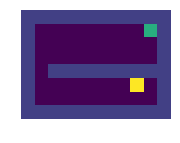

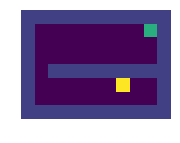

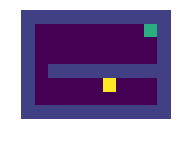

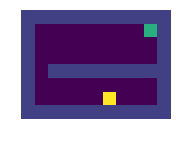

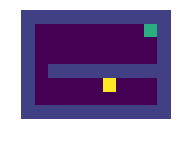

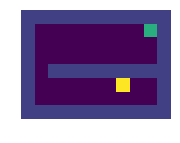

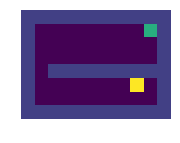

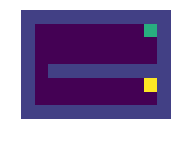

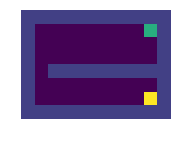

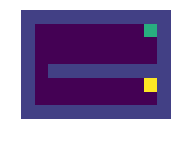

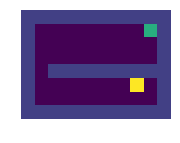

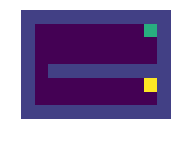

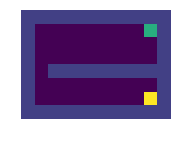

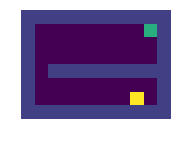

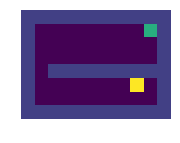

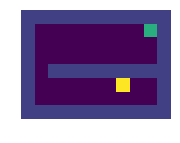

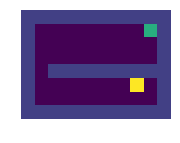

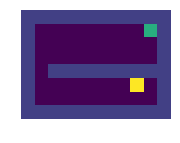

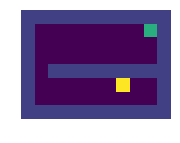

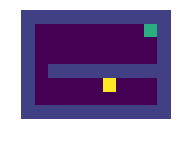

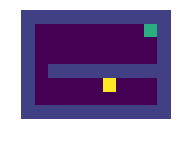

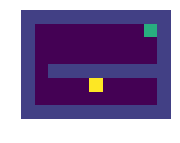

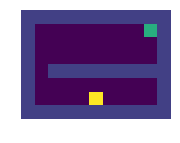

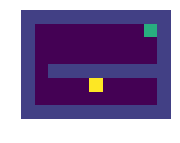

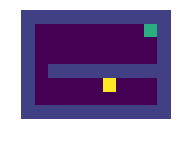

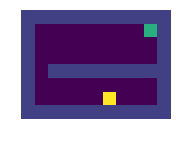

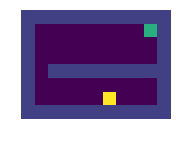

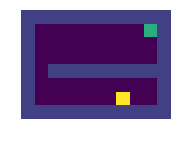

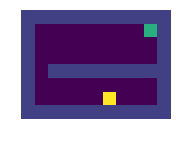

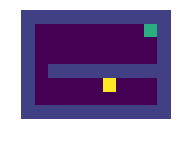

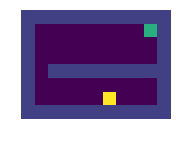

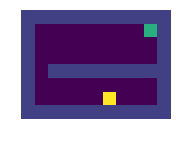

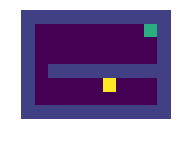

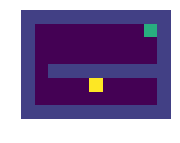

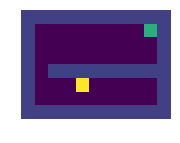

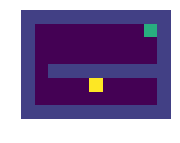

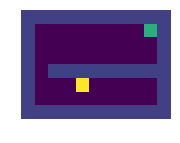

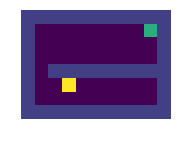

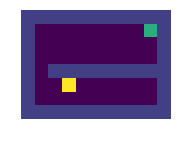

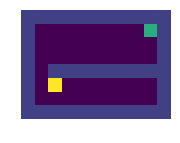

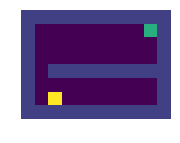

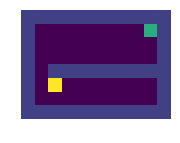

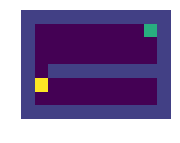

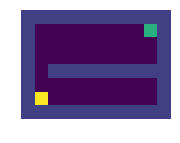

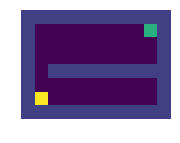

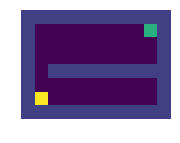

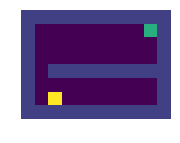

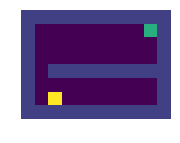

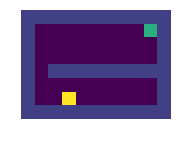

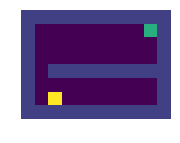

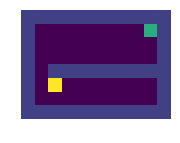

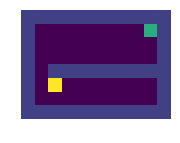

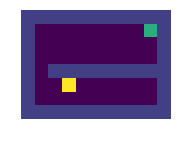

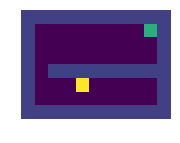

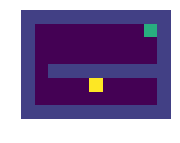

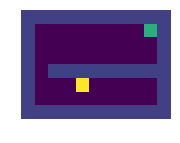

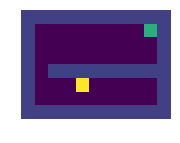

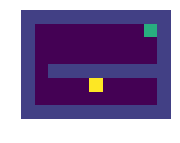

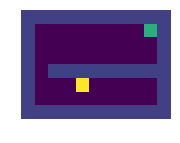

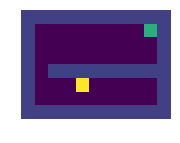

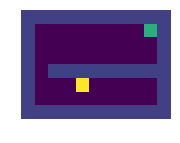

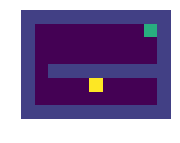

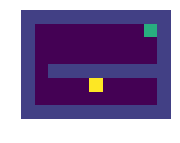

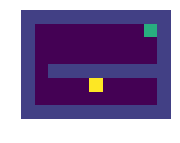

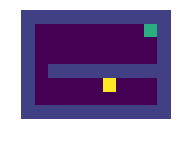

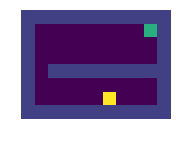

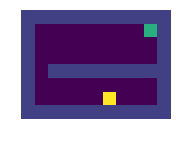

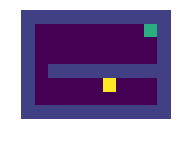

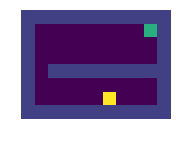

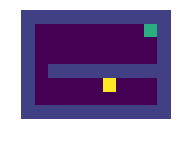

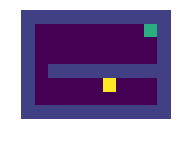

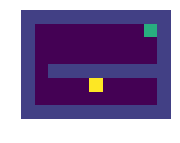

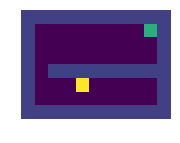

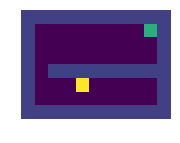

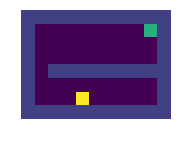

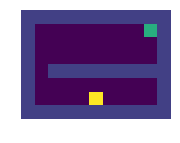

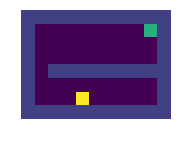

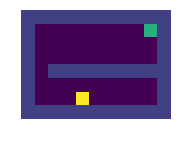

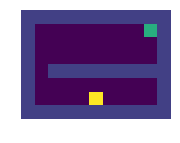

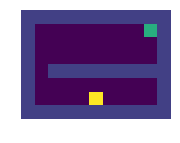

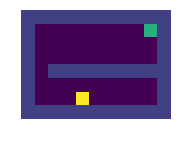

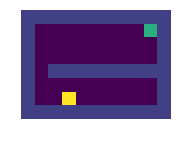

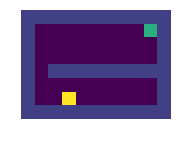

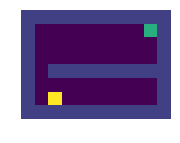

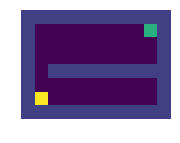

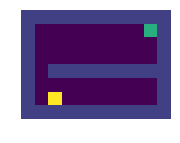

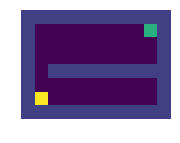

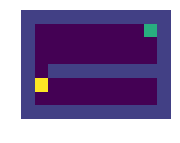

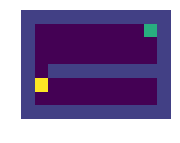

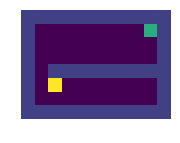

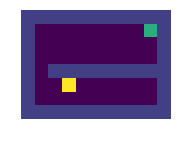

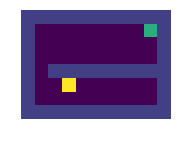

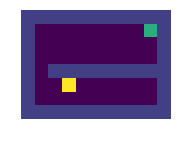

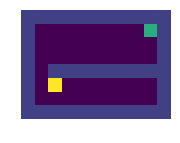

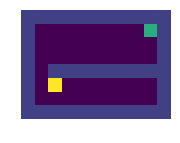

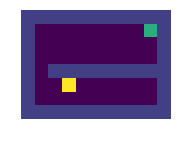

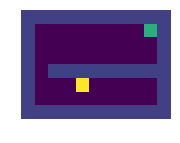

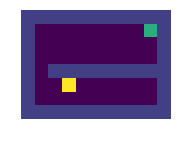

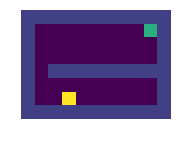

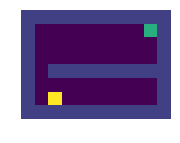

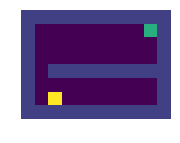

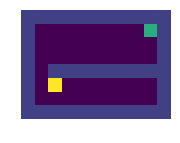

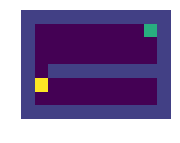

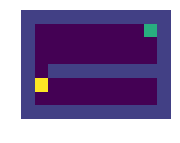

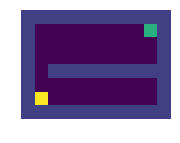

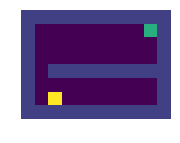

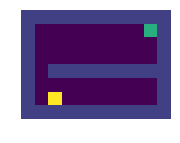

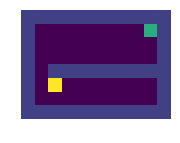

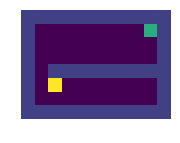

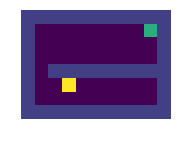

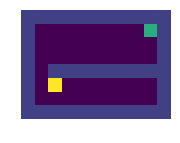

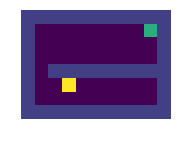

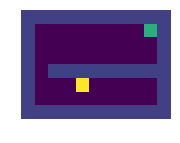

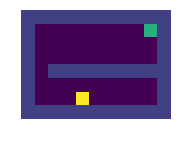

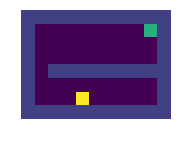

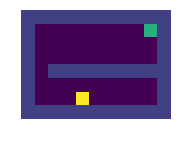

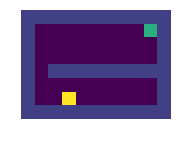

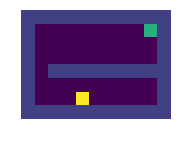

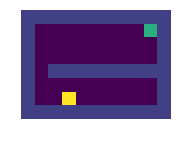

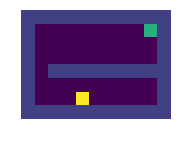

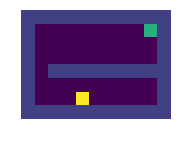

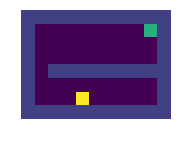

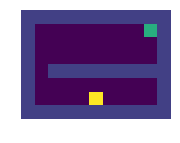

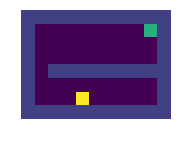

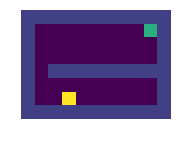

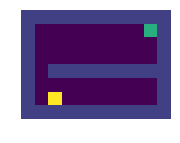

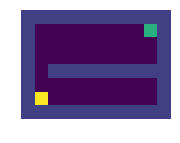

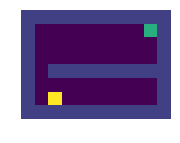

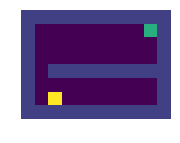

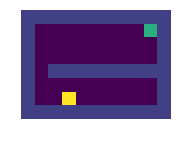

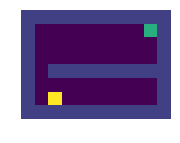

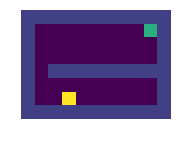

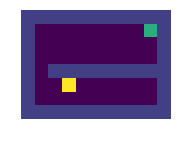

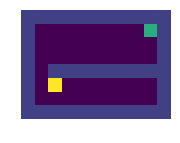

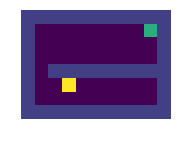

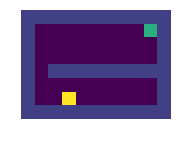

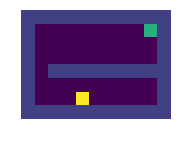

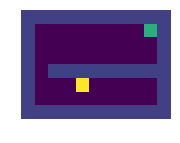

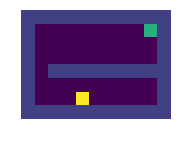

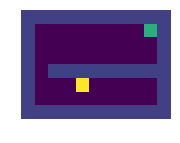

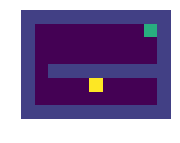

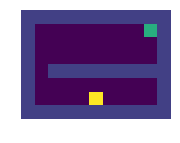

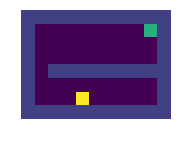

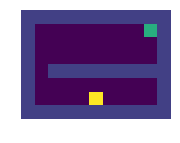

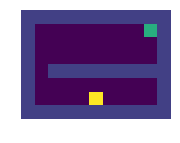

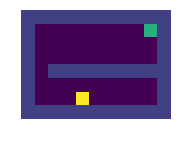

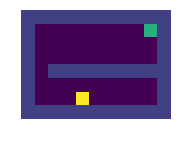

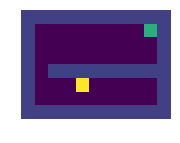

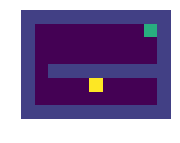

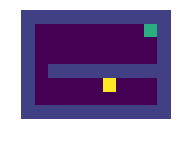

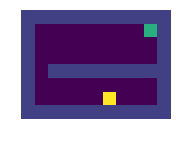

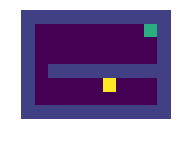

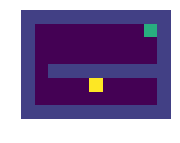

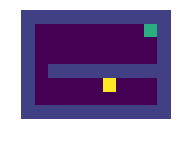

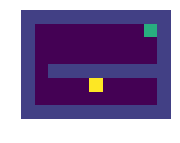

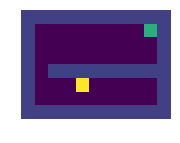

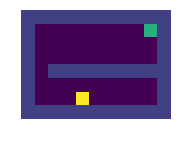

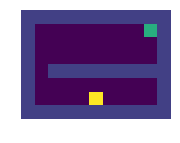

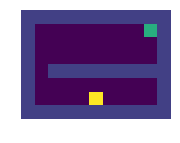

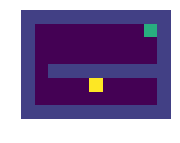

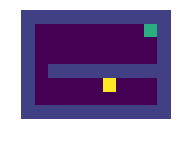

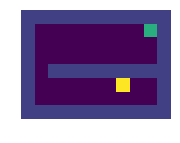

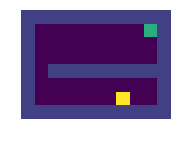

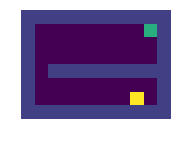

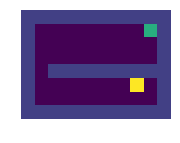

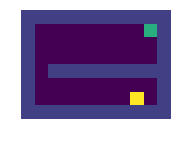

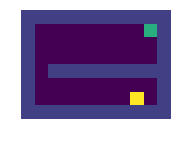

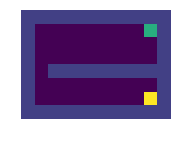

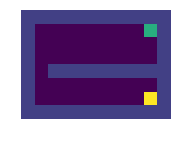

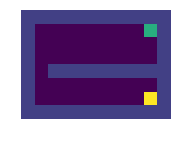

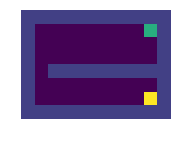

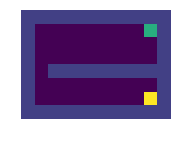

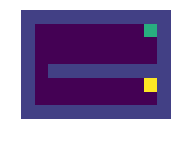

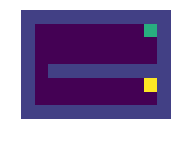

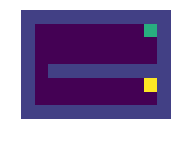

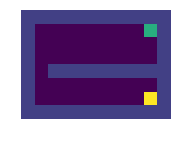

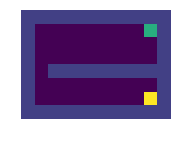

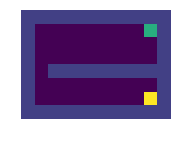

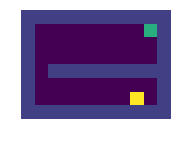

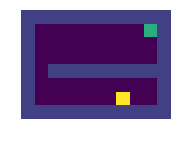

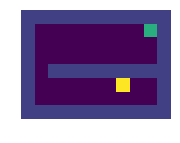

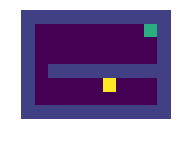

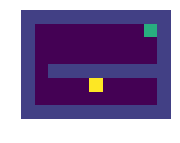

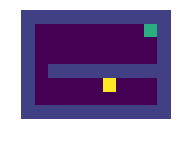

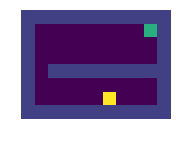

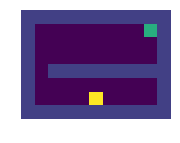

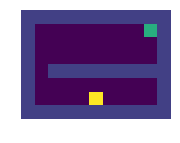

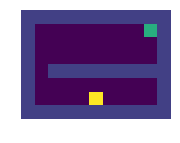

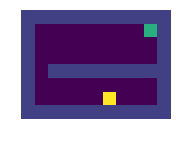

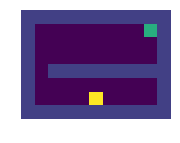

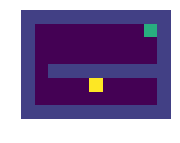

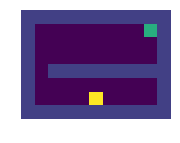

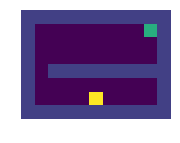

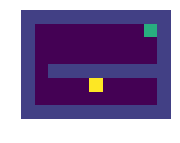

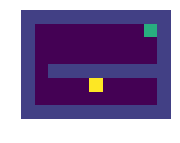

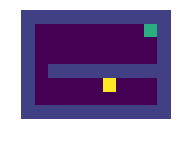

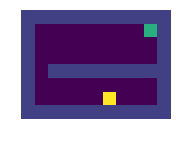

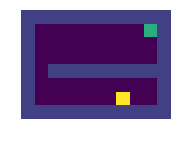

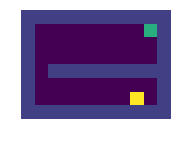

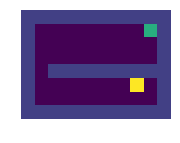

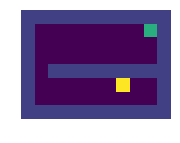

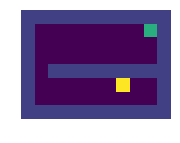

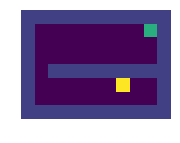

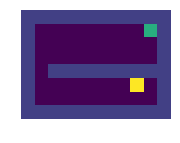

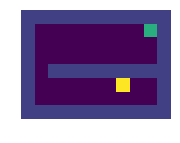

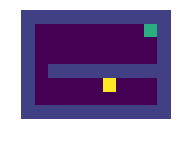

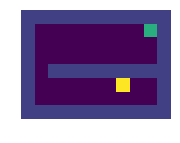

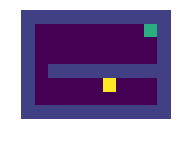

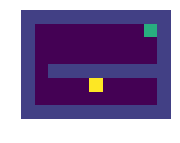

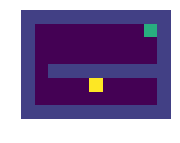

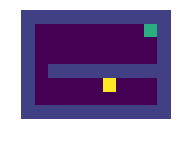

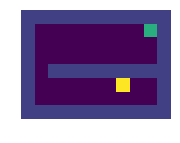

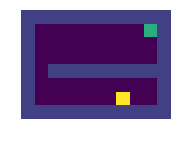

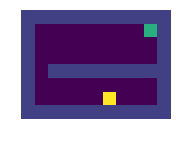

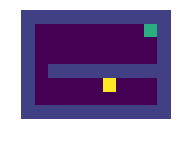

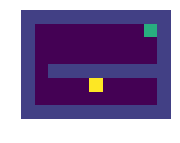

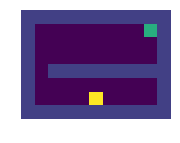

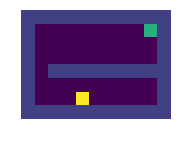

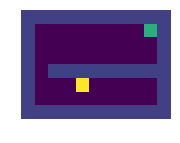

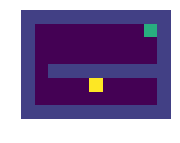

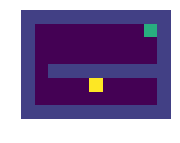

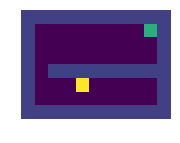

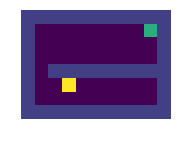

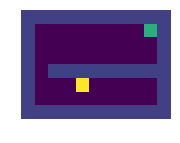

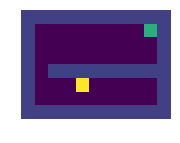

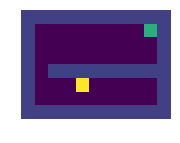

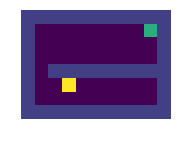

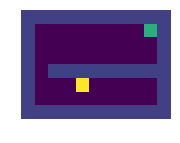

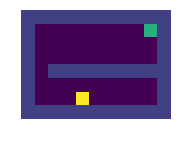

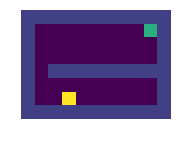

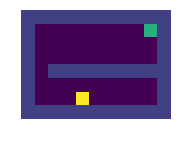

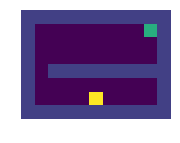

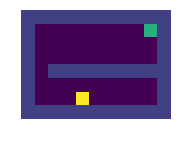

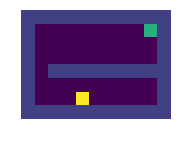

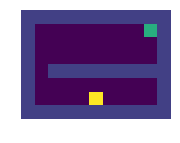

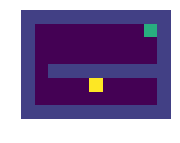

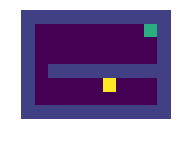

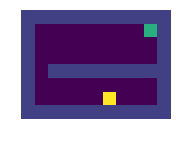

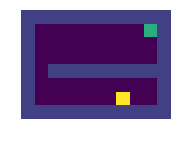

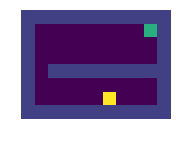

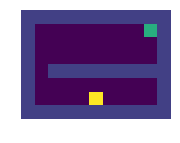

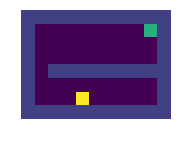

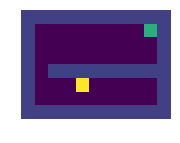

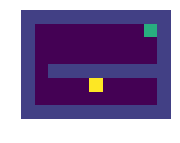

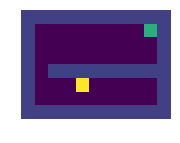

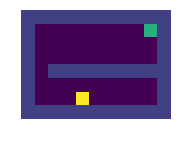

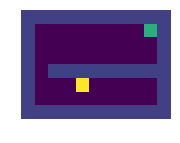

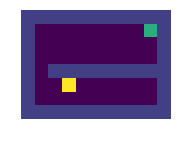

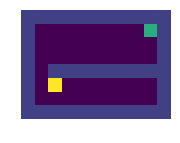

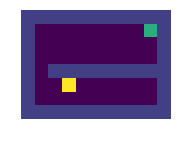

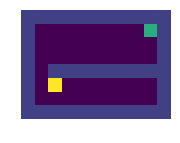

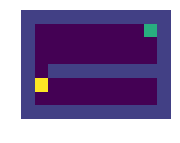

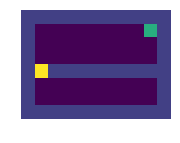

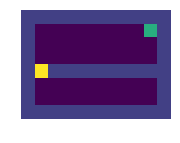

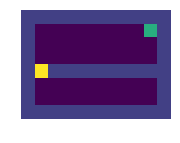

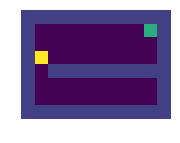

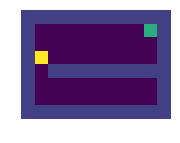

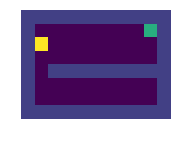

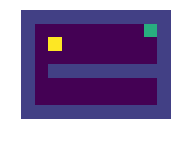

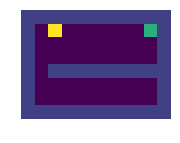

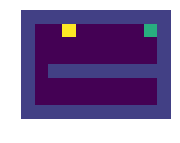

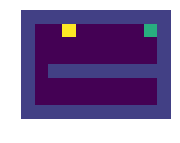

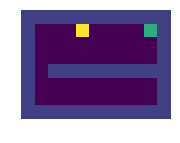

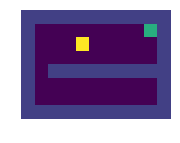

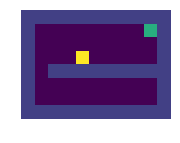

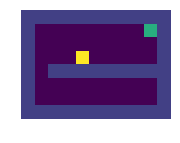

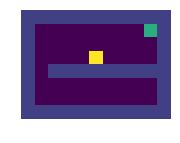

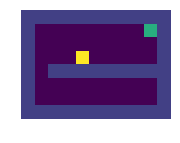

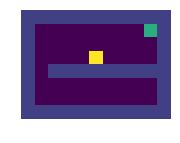

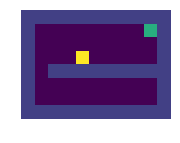

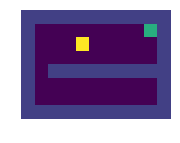

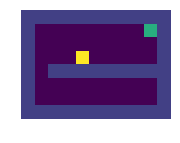

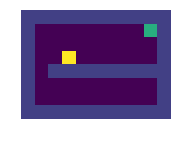

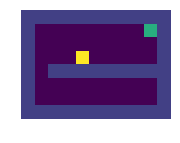

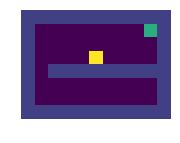

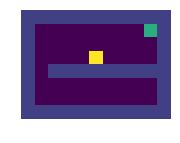

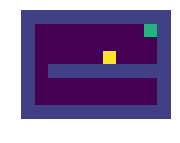

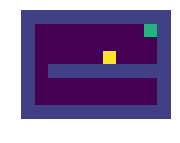

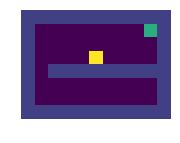

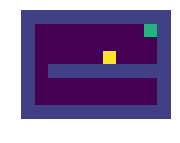

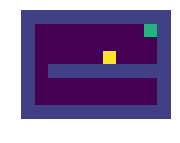

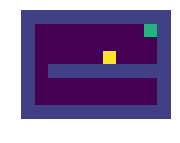

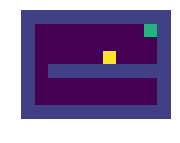

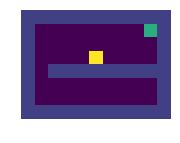

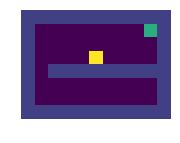

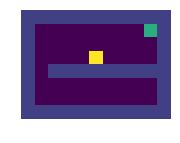

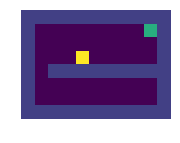

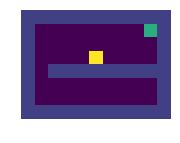

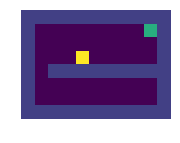

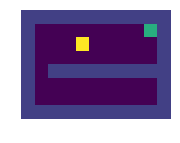

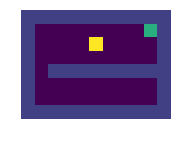

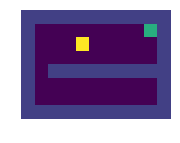

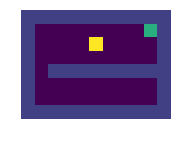

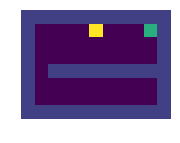

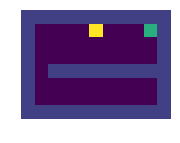

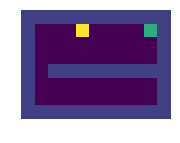

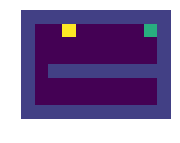

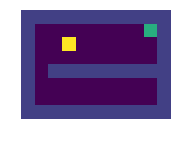

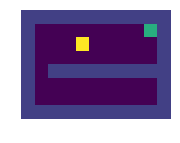

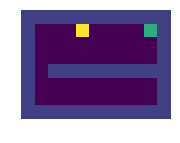

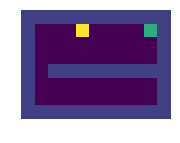

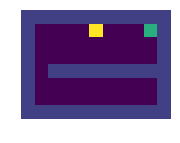

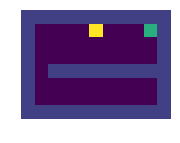

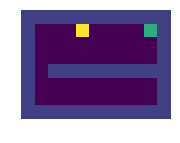

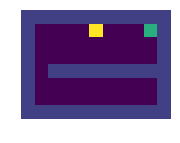

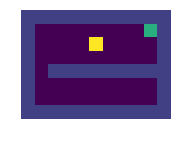

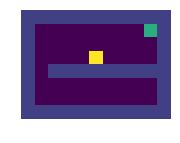

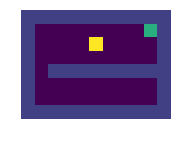

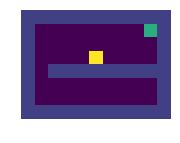

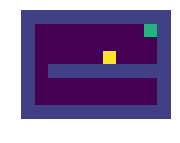

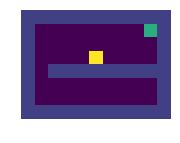

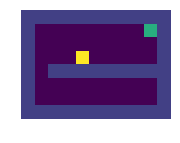

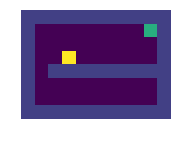

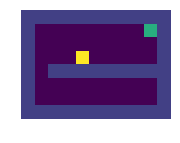

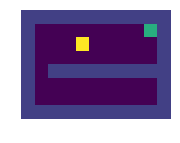

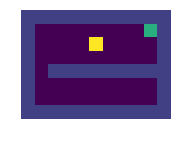

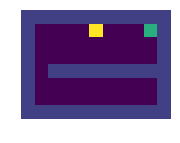

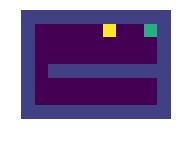

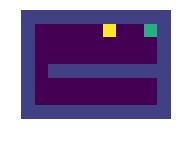

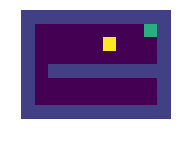

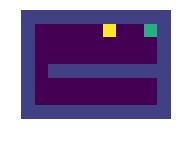

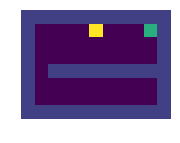

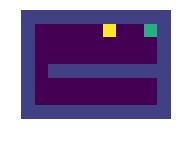

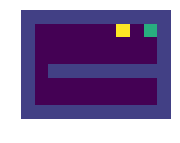

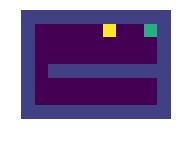

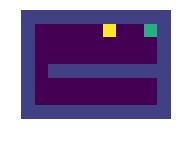

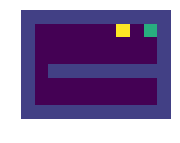

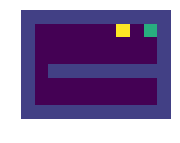

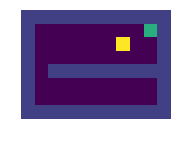

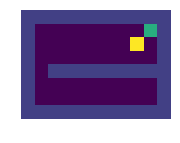

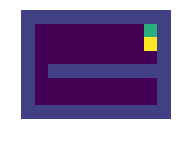

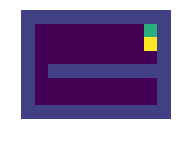

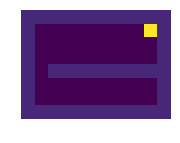

GAME OVER


In [10]:
MAZE_ART = ['###########',
            '#         #',
            '#         #',
            '#         #',
            '######### #',
            '#         #',
            '#         #',
            '###########']

MAZE_4RT = ['###########',
            '#         #',
            '#         #',
            '#         #',
            '# #########',
            '#         #',
            '#         #',
            '###########']

#
board = Board()

# Instanciates our game object
init_art(MAZE_ART, (6, 4))
game = make_game(MAZE_ART)
steps = 0

# Finalize the engine. Set-up and compute the first observation of the game
obs, reward, gamma = game.its_showtime()
show_board(obs)

# Take actions at random until termination
while not(game.game_over) and steps < 10:
    a = np.random.randint(4)
    obs, reward, gamma = game.play(a)
    show_board(obs)
    steps += 1
print("Changing Maze")

position = np.array(obs.layers['P'])
position = np.unravel_index(position.argmax(), position.shape)
init_art(MAZE_4RT, position)
game2 = make_game(MAZE_4RT)

obs, reward, gamma = game2.its_showtime()
show_board(obs)

while not(game2.game_over):
    a = np.random.randint(4)
    obs, reward, gamma = game2.play(a)
    show_board(obs)
    steps += 1
print('GAME OVER')